# Построение движка для игр на pygame - урок 6

## Повторение

После написания первой игры мы можем заметить, что появилось множество методов, вначале цикла которые нам приходится постоянно объявлять в правильном порядке:

In [4]:
from first_engine.game import Game
from first_engine.objects import Object


class FirstGame(Game):

    def run(self):
        hero = Object(parent=self.surface, speed=4, x=100, y=100)
        game_over = False

        while self.RUNNER:
            if not game_over:
                self.fps_counter(60)
                self.window_borders(objects=[hero])
                self.display_update()
                self.window_fill()

                hero.blit()
                hero.motion_control()

            for event in self.events():
                # print(event)  # отслеживание событий
                self.close(event)


FirstGame(width=400, height=400).run()

Давайте объединим их в один метод __cycle_init()__

In [ ]:
"""
Модуль с основным классом-конструктором Game - для создания игры.
"""

import pygame


class Game:
    ...

    def __init__(self, width=400, height=300, color=(0, 0, 0)): ...

    @staticmethod
    def display_update(): ...

    @staticmethod
    def events(): ...

    def window_fill(self): ...

    def fps_counter(self, FPS=30) -> None: ...

    def close(self, event) -> None: ...

    def window_borders(self, objects): ...

    def cycle_init(self, objects: list = None, FPS=30):
        """
        Метод объединяющий в себе все необходимые методы инициализирующие работу главного цикла
        """
        self.fps_counter(FPS)
        if objects:
            self.window_borders(objects=objects)
        self.display_update()
        self.window_fill()

Теперь стартовый код будет выглядеть так:

In [1]:
from first_engine.game import Game
from first_engine.objects import Object


class FirstGame(Game):

    def run(self):
        
        # Здесь описываем переменные и объекты
        
        game_over = False
        while self.RUNNER:
            if not game_over:
                self.cycle_init()
                
                # Здесь описываем логику игры

            for event in self.events():
                # print(event)  # отслеживание событий
                self.close(event)


FirstGame().run()

pygame 2.0.1 (SDL 2.0.14, Python 3.7.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


Так же на основе нашей первой игры мы поняли, что нужно назначать координаты объектов отдельно, а распологать объект по этим координатам отдельно, поэтому изменим метод __motion()__ на метод __replace()__ и модифицируем его, а так же в методе __motion_control()__ внесем изменения:

In [ ]:
import pygame


class Object:

    def __init__(self, parent: pygame.Surface,
                 width=40, height=40, x=0, y=0,
                 color=(255, 255, 255),
                 speed=1): ...

    def blit(self): ...

    def recolor(self, color): ...

    def __diagonal_speed(self): ...

    def replace(self, x=None, y=None): # раньще был motion()
        if x: # добавим эти условия, что бы можно было назначать произвольное положение объектов, если понадобится
            self.x = x
        if y:
            self.y = y

        self.body.x, self.body.y = self.x, self.y

    def motion_control(self):
        left = pygame.key.get_pressed()[97]
        right = pygame.key.get_pressed()[100]
        up = pygame.key.get_pressed()[119]
        down = pygame.key.get_pressed()[115]

        speed = self.__diagonal_speed() if (left + right + up + down) > 1 else self.speed
        
        # так как тело округляет свои координаты в меньшую сторону,
        # если ему присваивается число с плавающей точкой, то мы будим прибавлять 1 к скорости
        self.x += right * (speed + 1) if speed % 1 != 0 else right * speed
        self.y += down * (speed + 1) if speed % 1 != 0 else down * speed
        self.x -= left * speed
        self.y -= up * speed

        self.replace() # здась заменяем motion() на replace()
        return -left * speed, right * speed, -up * speed, down * speed # возвращаем скорость для каждого направления движения 

    def change_speed(self, speed): ...

## Сопротивление объектов

Достаточно сложный вопрос. который заключается в том, как нам описать сопротивление объектов.

Хотя на первый взгляд все кажется достаточно просто:

In [1]:
from first_engine.game import Game
from first_engine.objects import Object
import pygame.image


class FirstGame(Game):

    def run(self):
        
        # создаем героя
        hero = Object(self.surface, speed=4)
        
        # создаем преграду
        wall = Object(self.surface, x=100, y=100, width=100, height=100, color=(255, 200, 200))

        game_over = False
        while self.RUNNER:
            if not game_over:
                self.cycle_init(objects=[hero], FPS=60)

                # Отрисовка героя, и подключение метода перемещения
                hero.blit()
                hero.motion_control()
                
                # Отрисовка преграды 
                wall.blit()

                # Колизия объектов
                if wall.body.colliderect(hero.body): # если колизия есть,
                    # Тогда проверяем, с какой стороны она происходит и переназначаем положение героя
                    if hero.body.right > wall.body.left:
                        hero.body.right = wall.body.left
                    elif hero.body.left < wall.body.right:
                        hero.body.left = wall.body.right
                    elif hero.body.bottom > wall.body.top:
                        hero.body.bottom = wall.body.top
                    elif hero.body.top < wall.body.bottom:
                        hero.body.top = wall.body.bottom

            for event in self.events():
                # print(event)  # отслеживание событий
                self.close(event)


FirstGame(width=400, height=400).run()

pygame 2.0.1 (SDL 2.0.14, Python 3.7.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


Но если мы запустим этот код, то столкнемся с проблемой, дело в том, что проверяться будет только первое условие.

Мы можем подумать, а что если проверять каждое условие по отдельности?

In [2]:
from first_engine.game import Game
from first_engine.objects import Object
import pygame.image


class FirstGame(Game):

    def run(self):
        
        # создаем героя
        hero = Object(self.surface, speed=4)
        
        # создаем преграду
        wall = Object(self.surface, x=100, y=100, width=100, height=100, color=(255, 200, 200))

        game_over = False
        while self.RUNNER:
            if not game_over:
                self.cycle_init(objects=[hero], FPS=60)

                # Отрисовка героя, и подключение метода перемещения
                hero.blit()
                hero.motion_control()
                
                # Отрисовка преграды 
                wall.blit()

                # Колизия объектов
                if wall.body.colliderect(hero.body): # если колизия есть,
                    # Тогда проверяем, с какой стороны она происходит и переназначаем положение героя
                    if hero.body.right > wall.body.left:
                        hero.body.right = wall.body.left
                    if hero.body.left < wall.body.right:
                        hero.body.left = wall.body.right
                    if hero.body.bottom > wall.body.top:
                        hero.body.bottom = wall.body.top
                    if hero.body.top < wall.body.bottom:
                        hero.body.top = wall.body.bottom

            for event in self.events():
                # print(event)  # отслеживание событий
                self.close(event)


FirstGame(width=400, height=400).run()

Тут становится все еще хуже, так как, таперь условия начинают противоречить друг другу.

# Задача:

- Разберитесь в этом эффекте и попробуйте на теоретическом уровне придумать решения этой проблемы.

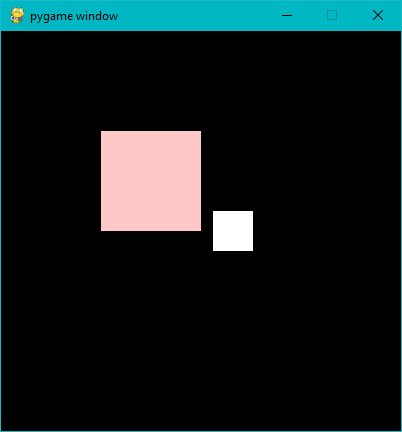

Одно из способов решения этой задачи - это первоначальное определение, с какой стороны произошло столкновение. Как это сделать?
Ну например можно расчитать степень погружение героя в преграду. И в зависимости от того, с какой стороны герой сильнее проникает в преграду, ту сторону и подключать к сопротивлению.

У этого подхода так же есть свой недостаток, который заключается в том, что если скорость движущегося объекта за 1 фрейм больше шитины препятствия, что дружущийся объект просто пройдет это препятствие насквозь!

In [1]:
from first_engine.game import Game
from first_engine.objects import Object


class FirstGame(Game):

    def run(self):

        hero = Object(self.surface, speed=4)
        wall = Object(self.surface, x=100, y=100, width=100, height=100, color=(255, 200, 200))

        game_over = False
        while self.RUNNER:
            if not game_over:
                self.cycle_init(objects=[hero], FPS=60)

                # Отрисовка объектов
                hero.blit()
                hero.motion_control()

                wall.blit()

                # Колизия
                if wall.body.colliderect(hero.body):  # Если происходит коллизия
                    # Определяем с какой стороны произошло столкновение

                    # Считаем глубину погружения с каждой стороны
                    resist_sides = {
                        'left': abs(wall.body.left - hero.body.right),
                        'right': abs(wall.body.right - hero.body.left),
                        'top': abs(wall.body.top - hero.body.bottom),
                        'bottom': abs(wall.body.bottom - hero.body.top)
                    }

                    # Находим ключ с минимальным погружением
                    min_dip = [key for key, val in resist_sides.items() if val == min(resist_sides.values())]

                    # Ну а теперь задействуем те стороны, которые у нас определились
                    if 'left' in min_dip:
                        hero.body.right = wall.body.left
                    elif 'right' in min_dip:
                        hero.body.left = wall.body.right
                    elif 'top' in min_dip:
                        hero.body.bottom = wall.body.top
                    elif 'bottom' in min_dip:
                        hero.body.top = wall.body.bottom

            for event in self.events():
                # print(event)  # отслеживание событий
                self.close(event)


FirstGame(width=400, height=400).run()

pygame 2.0.1 (SDL 2.0.14, Python 3.7.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


Этот метод показывает себя не плохо, но и у него так же есть свой недостаток, который заключается в том, что если скорость движущегося объекта за 1 фрейм больше шитины препятствия, что дружущийся объект просто пройдет это препятствие насквозь!

Можно добавить его в методы класса __Object__.

In [ ]:
import pygame


class Object:
    def __init__(self, parent: pygame.Surface,
                 width=40, height=40, x=0, y=0,
                 color=(255, 255, 255),
                 speed=1):...

    def blit(self):...

    def recolor(self, color):...

    def __diagonal_speed(self):...

    def replace(self, x=None, y=None):...

    def motion_control(self):...

    def change_speed(self, speed):...

    def resistance(self, objects: list):
        for obj in objects:
            collision = self.body.colliderect(obj.body)
            if collision:
                resist_sides = {
                    'left': abs(self.body.left - obj.body.right),
                    'right': abs(self.body.right - obj.body.left),
                    'top': abs(self.body.top - obj.body.bottom),
                    'bottom': abs(self.body.bottom - obj.body.top)
                }

                # Находим минимальное погружение
                min_dip = [key for key, val in resist_sides.items() if val == min(resist_sides.values())]

                # Ну а теперь задействуем те стороны, которые у нас определились
                if 'left' in min_dip:
                    obj.body.right = self.body.left
                elif 'right' in min_dip:
                    obj.body.left = self.body.right
                elif 'top' in min_dip:
                    obj.body.bottom = self.body.top
                elif 'bottom' in min_dip:
                    obj.body.top = self.body.bottom

                return collision
        return 0

У нас в классе накопилось большое число методов, давайте разобъем эти методы по отдельным классам, что бы как то разгрузить родительский класс и сделать его более универсальным. Это позволит нам масштабировать код, быстро ориентироваться в коде и интуитивно понимать возможности классов.

In [ ]:
import pygame


class Object:
    def __init__(self, parent: pygame.Surface, width=40, height=40, x=0, y=0, color=(255, 255, 255)):
        self.parent = parent
        self.x, self.y = x, y
        self.color = color

        self.skin = pygame.Surface(size=(width, height))
        self.skin.fill(color=color)
        self.body = self.skin.get_rect(topleft=(x, y))

    def blit(self):
        return self.parent.blit(source=self.skin, dest=self.body)

    def recolor(self, color):
        self.skin.fill(color=color)
        return color

    def replace(self, x=None, y=None):
        if x:
            self.x = x
        if y:
            self.y = y
        self.body.x = self.x
        self.body.y = self.y


class Character(Object):
    def __init__(self, parent: pygame.Surface, width=40, height=40, x=0, y=0, color=(255, 255, 255), speed=1):
        super().__init__(parent, width, height, x, y, color)
        self.speed = speed

    def __diagonal_speed(self):
        speed_xy = (self.speed ** 2 + self.speed ** 2) ** (1 / 2)  # находим длину вектора x + y по пифагору
        speed_xy = self.speed / speed_xy  # находим долю скорости от суммы векторов
        speed_xy *= self.speed  # теперь находим скорость по диагонали
        return speed_xy

    def motion_control(self):
        left = pygame.key.get_pressed()[97]
        right = pygame.key.get_pressed()[100]
        up = pygame.key.get_pressed()[119]
        down = pygame.key.get_pressed()[115]

        speed = self.__diagonal_speed() if (left + right + up + down) > 1 else self.speed

        self.x -= left * speed
        self.x += right * (speed + 1) if speed % 1 != 0 else right * speed
        self.y -= up * speed
        self.y += down * (speed + 1) if speed % 1 != 0 else down * speed

        self.replace()
        return -left * speed, right * speed, -up * speed, down * speed

    def change_speed(self, speed):
        self.speed = speed
        return speed


class Barrier(Object):
    def __init__(self, parent: pygame.Surface, objects: list, width=40, height=40, x=0, y=0, color=(255, 255, 255)):
        super().__init__(parent, width, height, x, y, color)
        self.objects = objects

    def resistance(self):
        for obj in self.objects:
            collision = self.body.colliderect(obj.body)
            if collision:
                resist_sides = {
                    'left': abs(self.body.left - obj.body.right),
                    'right': abs(self.body.right - obj.body.left),
                    'top': abs(self.body.top - obj.body.bottom),
                    'bottom': abs(self.body.bottom - obj.body.top)
                }
                min_dip = [key for key, val in resist_sides.items() if val == min(resist_sides.values())]

                if 'left' in min_dip:
                    obj.body.right = self.body.left
                elif 'right' in min_dip:
                    obj.body.left = self.body.right
                elif 'top' in min_dip:
                    obj.body.bottom = self.body.top
                elif 'bottom' in min_dip:
                    obj.body.top = self.body.bottom

                return collision
        return 0